In [ ]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define Project Folder
FOLDERNAME = 'Colab\ Notebooks/database'
%cd drive/MyDrive/$FOLDERNAME

# Define the base path
base_path = '/content/drive/MyDrive/Colab Notebooks/database'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/database


In [ ]:
# Import Package
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# Read files
def read_csv_files(base_path):
    # List to store the tuples
    data_list = []

    # Iterate over each parent folder prefix from 1 to 6
    for folder_num in range(6):
        # Define the prefix for parent folders
        prefix = f"{folder_num+1}_"

        # Find all matching parent folders
        parent_folders = [folder for folder in os.listdir(base_path) if folder.startswith(prefix)]

        # Iterate over each matching parent folder
        for parent_folder in parent_folders:
            parent_folder_path = os.path.join(base_path, parent_folder)

            # Find the child folder
            child_folder_path = os.path.join(parent_folder_path, "21_4")

            # Check if the child folder exists
            if os.path.exists(child_folder_path):
                # Find all CSV files in the '21_4' subfolder
                csv_files = [f for f in os.listdir(child_folder_path) if f.endswith(".csv")]
                # Read each CSV file using pandas and append to the list
                for file_name in csv_files:
                    file_path = os.path.join(child_folder_path, file_name)
                    pd_data = pd.read_csv(file_path, header = None)
                    data_list.append((pd_data, folder_num, file_name))

    return data_list
data_list = read_csv_files(base_path)

In [ ]:
# To check if the statistics are stored correctly
combined_df = []
labels = []

for df, file_num, _ in data_list:
  combined_df.append(df)
  labels.append(file_num)

# Data Augmentation
duplicate = [1, 2, 4]
for data, folder_num, _ in data_list:
    for i in duplicate:
        if folder_num == i:
            combined_df.append(data)
            labels.append(folder_num)
            combined_df.append(data)
            labels.append(folder_num)
    if folder_num == 1 or folder_num == 2 or folder_num == 3:
        combined_df.append(data)
        labels.append(folder_num)

# Randomly select half of folder_num == 5 and folder_num == 3
for folder_num in [1, 3, 5]:
    data_i = [data for data, num, _ in data_list if num == folder_num]
    data_i_labels = [num for _, num, _ in data_list if num == folder_num]
    num_to_select = len(data_i) // 2
    selected_indices = np.random.choice(len(data_i), num_to_select, replace=False)
    selected_data_i = [data_i[j] for j in selected_indices]
    selected_labels_i = [data_i_labels[j] for j in selected_indices]
    combined_df.extend(selected_data_i)
    labels.extend(selected_labels_i)

# Combine all DataFrames into one large DataFrame
combined_frame = np.array(combined_df)
labels = np.array(labels)
combined_frame = combined_frame.reshape(-1, 21, 1)

print('Shape of combined_frame:', combined_frame.shape)  # (len(data), 21)
print('Shape of combined_label:',labels.shape)

# Separate data into training set and validation set
train_data, val_data, train_labels, val_labels = train_test_split(combined_frame, labels, test_size=0.2, random_state=42)

Shape of combined_frame: (4570, 21, 1)
Shape of combined_label: (4570,)


In [ ]:
# Create tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
num_train = len(train_data)
num_val = len(val_data)
print('Shape of train_tensor:', train_tensor.shape)
print(f'Num_train: {num_train}, Num_val: {num_val}')

Shape of train_tensor: torch.Size([3656, 21, 1])
Num_train: 3656, Num_val: 914


In [ ]:
# Create Mini-batches
batch_size = 32
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print('Length of train_loader:', len(train_loader))

Length of train_loader: 115


In [ ]:
# Define LSTM model
class myRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  # Forward propagate LSTM
  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out[:, -1, :])
    return out

def extract_lstm_features(model, data_loader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            out, _ = model.lstm(x)  # Get the output from LSTM
            out = out[:, -1, :]  # Get the last hidden state
            features.extend(out.cpu().numpy())
            labels.extend(y.cpu().numpy())
    return np.array(features), np.array(labels)

Shape of lstm_train_features: (3656, 256)
Shape of lstm_val_features: (914, 256)


In [ ]:
# Set model parameters
input_size = 1                     # Number of features
hidden_size = 256                  # Number of hidden units
num_layers = 1                     # Number of LSTM layers
output_size = 6                    # Output size (for classification, assuming 6 classes)

In [ ]:
# Initialize the model
model = myRNN(input_size, hidden_size, num_layers, output_size)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
lstm_train_features, _ = extract_lstm_features(model, train_loader, device)
lstm_val_features, _ = extract_lstm_features(model, val_loader, device)
print(f'Shape of lstm_train_features: {lstm_train_features.shape}')
print(f'Shape of lstm_val_features: {lstm_val_features.shape}')

In [ ]:
# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Initialize lists to store loss and accuracy values
train_losses = []
val_accuracies = []

# Training Procedure
def train(num_epoch, model, train_loader, val_loader, device, loss_function, optimizer):
  for epoch in range(num_epoch):
    model.train()
    epoch_loss = 0
    for x, y in train_loader:
      x = x.to(device)
      y = y.to(device)
      scores = model(x)
      loss = loss_function(scores, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    evaluate_predictor(model, val_loader, device, epoch)

# Validating Procedure
def evaluate_predictor(model, val_loader, device, epoch):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for x, y in val_loader:
      x = x.to(device)
      y = y.to(device)
      scores = model(x)
      predictions = scores.max(1)[1]
      correct += predictions.eq(y).sum().item()
      total += y.size(0)
  val_accuracy = correct / total
  val_accuracies.append(val_accuracy)
  if (epoch + 1) % 100 == 0:
    print(f'Epoch[{epoch+1}], Accuracy: {val_accuracy:.4f}')

In [ ]:
# Start training
num_epoch = 800
train(num_epoch, model, train_loader, val_loader, device, loss_function, optimizer)

Epoch[100], Accuracy: 0.9212
Epoch[200], Accuracy: 0.9333
Epoch[300], Accuracy: 0.9672
Epoch[400], Accuracy: 0.9705
Epoch[500], Accuracy: 0.9278
Epoch[600], Accuracy: 0.9672
Epoch[700], Accuracy: 0.9748
Epoch[800], Accuracy: 0.9748


In [ ]:
# Make predictions on the validation set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)
        scores = model(x)
        predictions = scores.max(1)[1]
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

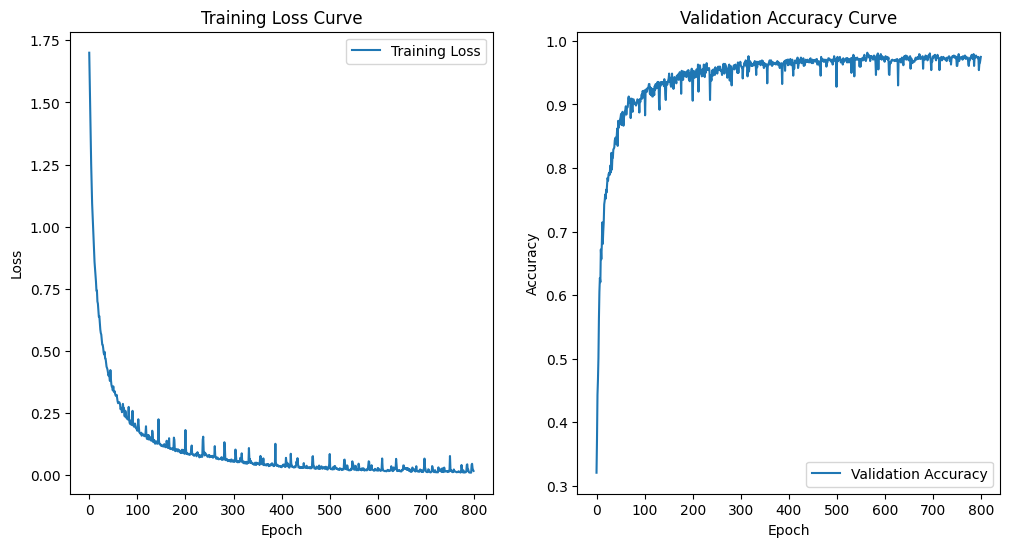

Accuracy: 0.9748358862144421
              precision    recall  f1-score   support

           0       1.00      0.95      0.98       149
           1       0.98      1.00      0.99       131
           2       0.97      1.00      0.98       267
           3       0.96      0.97      0.96       126
           4       0.95      0.97      0.96       120
           5       0.99      0.93      0.96       121

    accuracy                           0.97       914
   macro avg       0.98      0.97      0.97       914
weighted avg       0.98      0.97      0.97       914



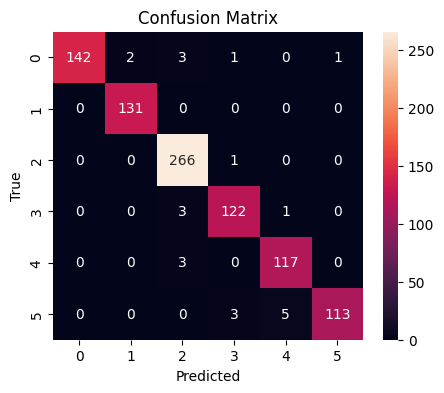

In [ ]:
# Plot loss curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.show()
# Compute classification report
print("Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds))
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=range(6), yticklabels=range(6))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()